In [23]:
from stable_baselines3 import PPO
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
import gym
import numpy as np
import sys
sys.path.append("../../")
from Hack import load, rl
from Forecasting import Bayesian_Forecast
from numpy import newaxis
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
epex = load.epex().load()

In [25]:
#Obtain the foreacsted samples and data
horizon = 2

datetimes,prices,samples,forecast = Bayesian_Forecast.evaluate(epex,
    horizon=horizon,
    forecast_start_index=0,
    forecast_end_index=-1,
    prior_length=48,
    nsamps=500,
    rho=0.3
)


* Note! The forecasting method does not work well without previous data.
* Therefore, to be safe, we here clip off the first month worth of data so that all forecasts from that point on will be reliable.

In [26]:
month_clip = 1440
epex = epex.iloc[month_clip:]
datetimes = datetimes[month_clip:]
samples = samples[:,month_clip:,-1]
forecast = forecast[month_clip:,-1]

samples_plot = samples[:,:,newaxis]   #Keep array 2D for plotting
forecast_plot = forecast[:,newaxis]


In [27]:
sigma = 95
alpha = (100 - sigma) / 2
upper = np.percentile(samples, [100 - alpha], axis=0)
lower = np.percentile(samples, [alpha], axis=0)
error = upper - lower
error = error[0]

In [28]:
price_array = epex['apx_da_hourly'].values

start_of_2020 = None
start_of_2021 = None

for idx, (i, row) in enumerate(epex.iterrows()):
    if i.year > 2019 and start_of_2020 is None:
        start_of_2020 = idx
    if i.year > 2020 and start_of_2021 is None:
        start_of_2021 = idx
        break
print(start_of_2020, start_of_2021)

11762 29330


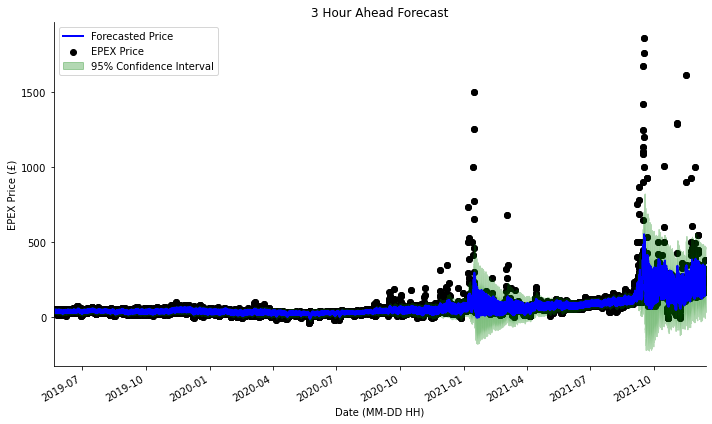

In [29]:
starts = [1000]

plot_start = starts[0] #Offset from the start date at which to begin the plot
plot_length = 45000

fig, ax = plt.subplots(figsize=(10,6))
ax = Bayesian_Forecast.plot_forecast(
    fig, ax,
    epex=epex,
    datetimes=datetimes,
    plot_start=plot_start,
    plot_length=plot_length,
    horizon=1,
    f=forecast_plot,
    samples=samples_plot,
    linewidth = 2,
    credible_interval=95,
    bool_plot_all_forecasts=False)

ax = Bayesian_Forecast.forecast_ax_style(ax=ax,
    ylabel='EPEX Price (£)',
    xlabel='Date (MM-DD HH)',
    title='3 Hour Ahead Forecast',
    legend=['Forecasted Price','EPEX Price','95% Confidence Interval']
    )


In [30]:
start_idx = month_clip + 0
end_idx = month_clip + 4*7*24*2 #start_of_2020 #4 * 2*24*7 #start_of_2020 # 2019->2020 # 2*24*7
obs_price_array = price_array[start_idx:end_idx]
forecast_price_array = forecast[start_idx:end_idx]
forecast_error = error[start_idx:end_idx]

power = 1 # MW
env = rl.energy_price_env(obs_price_array, window_size=24*2, power=power, forecast_price_array=forecast_price_array, forecast_error=forecast_error)
model = PPO(MlpPolicy, env, verbose=0)
check_env(env, warn=True)

In [31]:
test_prices = np.array([10,20,30,20,10])
test_forecast = np.array([20,30,20,10,0])
test_error = np.array([1,1,1,1,1])
power = 1 # MW
env = rl.energy_price_env(test_prices, window_size=3, power=power,start_energy=0,forecast_price_array=test_forecast,forecast_error=test_error)
state, reward, _, _ = env.step(rl.human2env(1))
print(state)
print(reward)

[20.    15.     0.425  1.    30.     1.   ]
-4.25


In [32]:
state, reward, _, _ = env.step(rl.human2env(1))
print(state)
print(reward)

[30.   20.    0.85  2.   20.    1.  ]
-8.5


In [33]:
env.get_reward(1,10,20,15,1)

15

Mean reward: -141.86145 +/- 0.0 	 Num episodes: 1


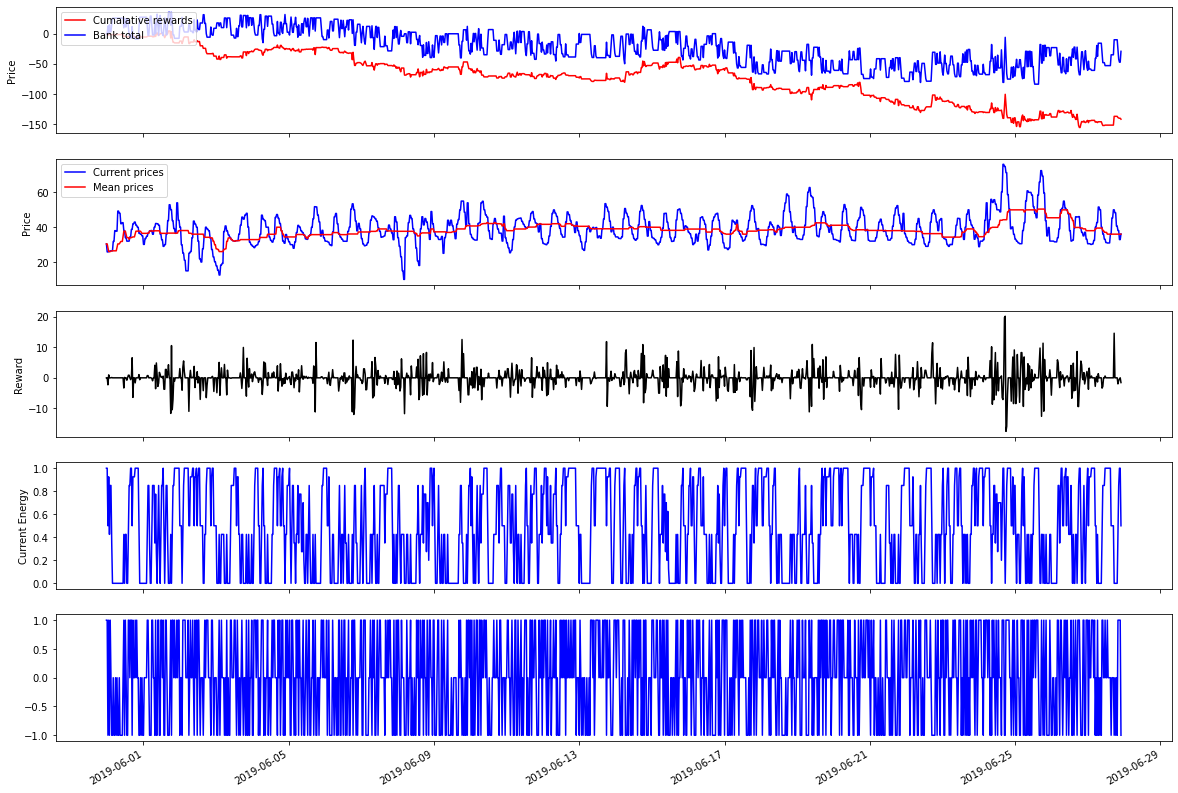

In [34]:
mean_reward_before_train = rl.evaluate(model, num_episodes=1, index = epex.index[start_idx:end_idx])

In [35]:
# Train the agent for 10000 steps
model.learn(total_timesteps=10000)
#model.save("../model_dir/trained_model")

# load model using loaded_model = PPO.load("path_to_model")

Mean reward: 660.06366 +/- 325.5897 	 Num episodes: 100


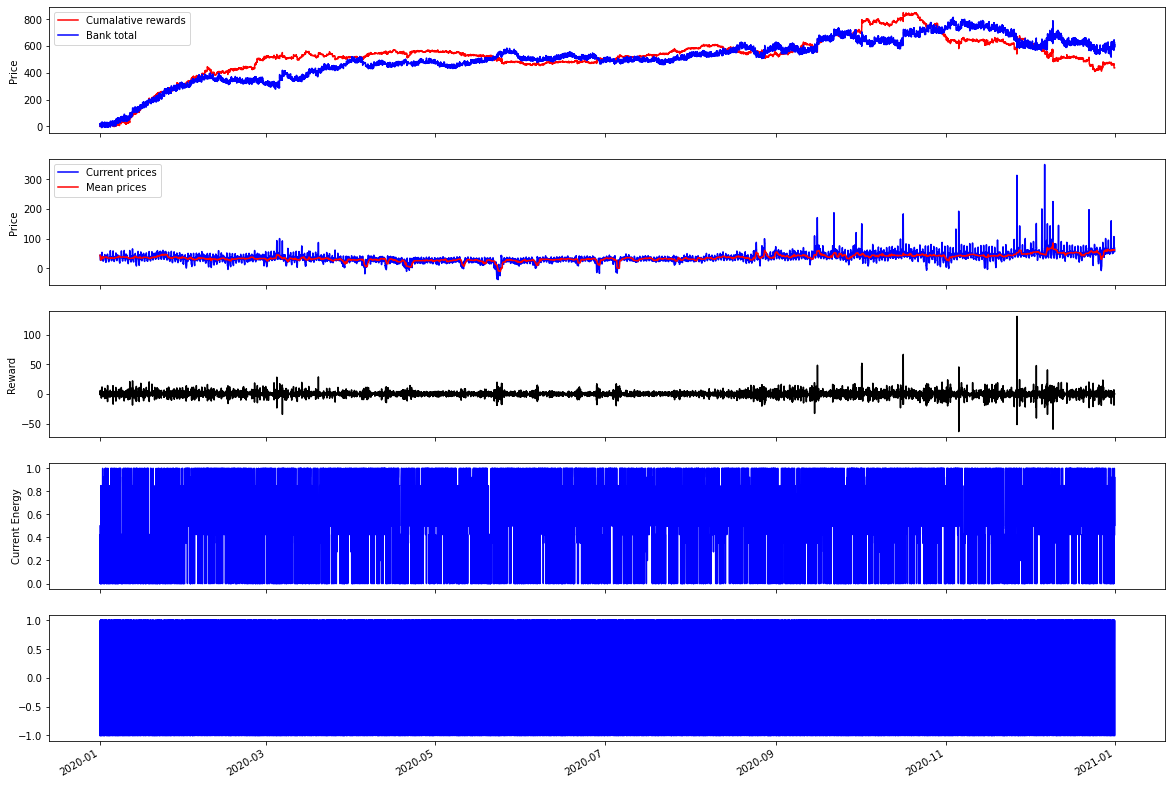

In [38]:
# Trained Agent, after training
period = '2020'
# period = 'sept'

if period == 'sept':
    # test on september
    test_start_idx = 42434 # end_idx # start_of_2020 # end_idx # start_of_2020 # 2*24*7
    test_end_idx =  test_start_idx + 4*7*24*2 # -1 # start_of_2021 # 2*end_idx # start_of_2021 # 30770 + 2*24*7
elif period == 'all':
    test_start_idx = 4*7*24*2
    test_end_idx =  -1
elif period == '2020':
    test_start_idx = start_of_2020
    test_end_idx =  start_of_2021
elif period == '2021':
    test_start_idx = start_of_2021
    test_end_idx =  -1

test_price_array = price_array[test_start_idx:test_end_idx]
test_forecast = forecast[test_start_idx:test_end_idx]
test_error = error[test_start_idx:test_end_idx]

new_env =  DummyVecEnv([lambda: rl.energy_price_env(test_price_array, power=power,forecast_price_array=test_forecast,forecast_error=test_error)])
mean_reward_after_train = rl.evaluate(model, new_env=new_env, num_episodes=100, index=epex.index[test_start_idx:test_end_idx])